In [6]:
import os
import shutil
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [9]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 299
BATCH_SIZE = 32

In [11]:
data_path = '/home/alena/Рабочий стол/Уник/наука о данных/inaturalist/images'

In [30]:
for subfolder in ['желтоносая', 'пестроносая',]:
    original_path = f'{data_path}/{subfolder}'
    original_data = os.listdir(original_path)

    n_samples = len(original_data)
    train_samples = int(n_samples * 0.75)
    valid_samples = int(n_samples * 0.1)

    train_path = os.path.join('train', subfolder)
    valid_path = os.path.join('valid', subfolder)
    test_path = os.path.join('test', subfolder)
    
    # Create class subfolders for training, validation, and testing:
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(valid_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Training images:
    for image in original_data[:train_samples]:
        original_file = os.path.join(original_path, image)
        new_file = data_path +'/train/'+ str(subfolder) + '/' + image
        shutil.copyfile(original_file, new_file)

    # Validation images:
    for image in original_data[train_samples:train_samples + valid_samples]:
        original_file = os.path.join(original_path, image)
        new_file = data_path +'/valid/'+ str(subfolder) + '/' + image
        shutil.copyfile(original_file, new_file)

    # Test images:
    for image in original_data[train_samples + valid_samples:]:
        original_file = os.path.join(original_path, image)
        new_file = data_path +'/test/'+ str(subfolder) + '/' + image
        shutil.copyfile(original_file, new_file)

In [31]:
print('train dataset')
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory= data_path + '/train',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
print('valid dataset')
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/home/alena/Рабочий стол/Уник/наука о данных/inaturalist/images/valid',
                                         target_size=(IMG_SIZE, IMG_SIZE), 
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
print('test dataset')
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/home/alena/Рабочий стол/Уник/наука о данных/inaturalist/images/test',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

train dataset
Found 1665 images belonging to 2 classes.
valid dataset
Found 226 images belonging to 2 classes.
test dataset
Found 332 images belonging to 2 classes.


In [36]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 150, 150, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 150, 150, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 150, 150, 32)         0         ['bn_Conv1[

In [37]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2, activation='softmax')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [38]:
base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [39]:
epochs_num = 20
history = model.fit(train_generator, validation_data=valid_generator,
                    epochs=epochs_num, steps_per_epoch=20, validation_steps=10)

Epoch 1/20
20/20 [==============================] - 24s 1s/step - loss: 0.6415 - accuracy: 0.6453 - val_loss: 0.5845 - val_accuracy: 0.7035
Epoch 2/20
20/20 [==============================] - 15s 726ms/step - loss: 0.5690 - accuracy: 0.7373
Epoch 3/20
20/20 [==============================] - 15s 721ms/step - loss: 0.5524 - accuracy: 0.7307
Epoch 4/20
20/20 [==============================] - 15s 758ms/step - loss: 0.4722 - accuracy: 0.8016
Epoch 5/20
20/20 [==============================] - 17s 836ms/step - loss: 0.4949 - accuracy: 0.7953
Epoch 6/20
20/20 [==============================] - 17s 843ms/step - loss: 0.4474 - accuracy: 0.8266
Epoch 7/20
20/20 [==============================] - 14s 701ms/step - loss: 0.4104 - accuracy: 0.8374
Epoch 8/20
20/20 [==============================] - 15s 731ms/step - loss: 0.4061 - accuracy: 0.8406
Epoch 9/20
20/20 [==============================] - 14s 689ms/step - loss: 0.3674 - accuracy: 0.8686
Epoch 10/20
20/20 [==============================] -

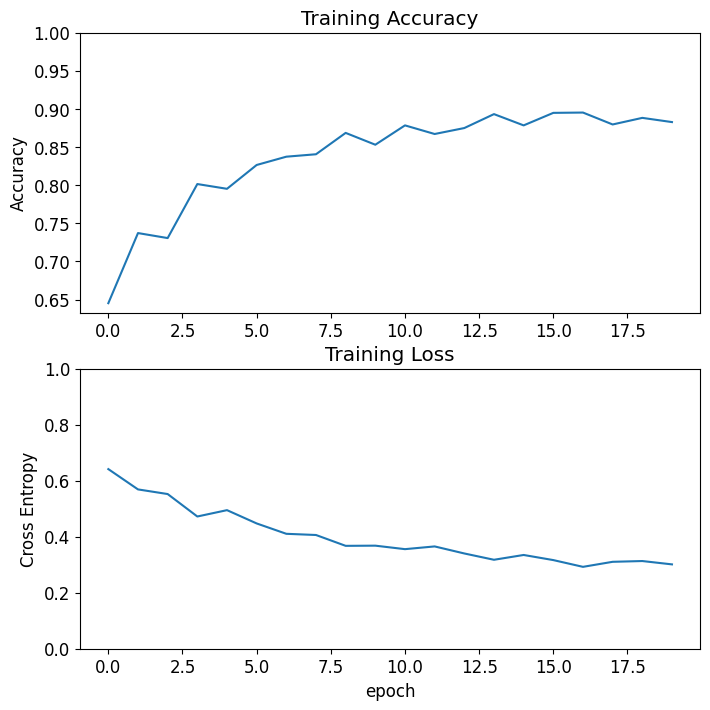

In [41]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc)
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
loss, accuracy = model.evaluate(test_generator, steps=10, verbose=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

10/10 - 8s - loss: 0.4050 - accuracy: 0.8438 - 8s/epoch - 777ms/step
Model performance on test images:
Accuracy = 0.84375
Loss = 0.40495190024375916


In [43]:
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

11/11 [==============================] - 9s 704ms/step


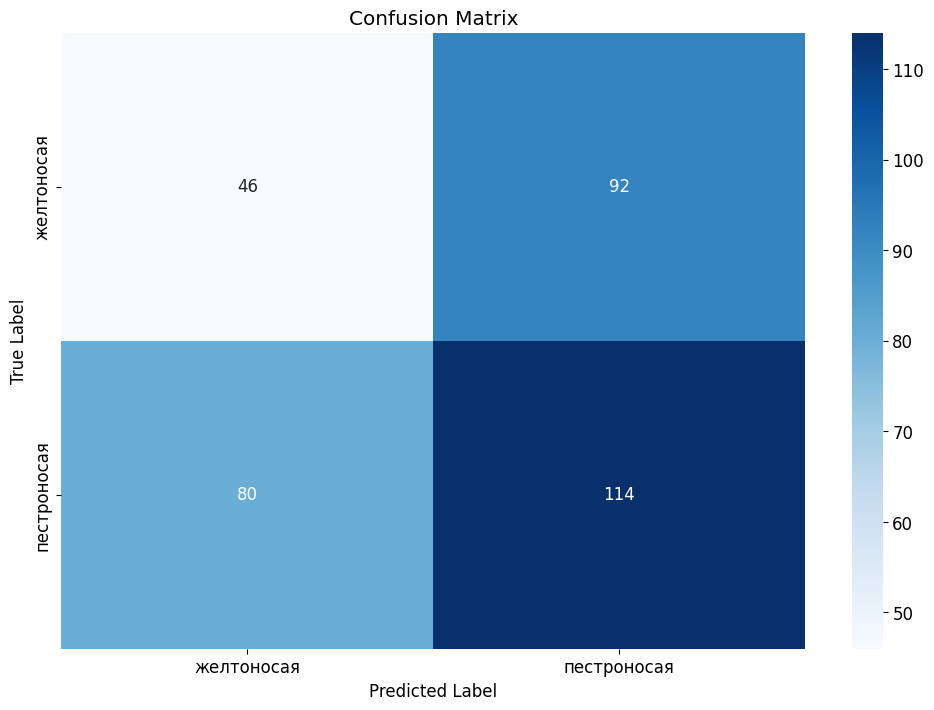

In [45]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted: желтоносая, Real: пестроносая')

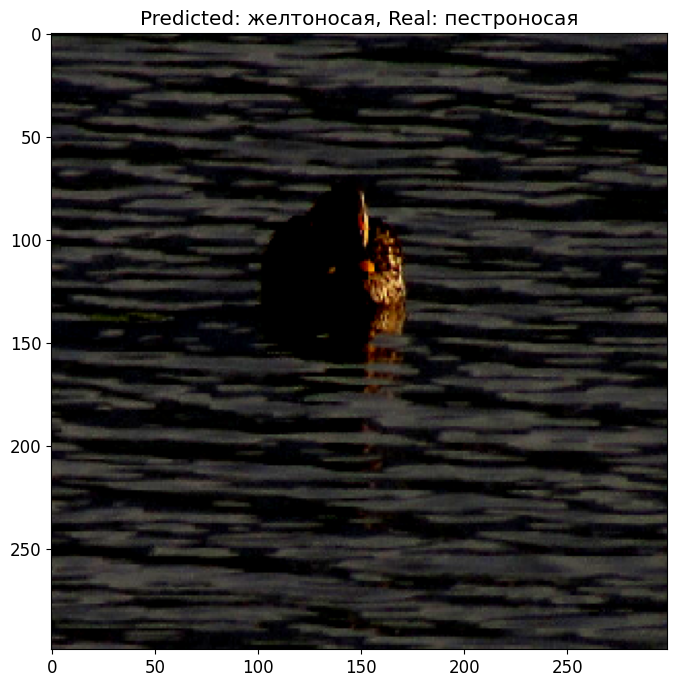

In [47]:
import random

random_index = random.randint(0, len(test_generator) - 1)
random_image, random_label = test_generator[random_index]
plt.imshow(random_image[0])
image_class = y_pred_classes[random_index]
mapping = {0:    'желтоносая',
           1:    'пестроносая'}
plt.title(f'Predicted: {mapping[image_class]}, Real: {mapping[np.argmax(random_label[0])]}')